# Import libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import time

# for audio
from IPython.display import Audio
import librosa

# for preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# for modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# For drive access
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


# define classes to extract features from audio files

In [2]:
class Framed:

  def __init__(self,
               dataframe,
               sr=16000,
               window_size_s=8.0,
               hop_size_s=4.0,
               augment=True
               ):
    """
    Instantiate the Framed class, create train and val dfs
    The extract_framed() method is automatically called to extract the framed audios and add to the train and val dfs

    Alternative, the extract_framed() method could be called separately if needed by passing a dataframe to it as parameter

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information
      sr (int): Sample rate of the audio files. Default = 16000
      window_size_s (float): Window size in seconds for framing the audio. Default = 8.0
      hop_size_s (float): Hop size in seconds for framing the audio. Default = 4.0
    """

    self.sr = sr
    self.frame_length = int(window_size_s * sr)
    self.frame_step = int(hop_size_s * sr)

    self.train_df, self.val_df = self._split_train_val(dataframe)

    self.extract_framed(self.train_df, augment=augment)
    self.extract_framed(self.val_df, augment=False)

  def _split_train_val(self, dataframe):
    """
    Split the dataframe to train and val based on predefined train/val column in the dataframe
    """
    train_df = dataframe[dataframe['data'] == 'train']
    train_df = train_df.sample(frac=1, random_state=1234)

    val_df = dataframe[dataframe['data'] == 'val']
    val_df = val_df.sample(frac=1, random_state=1234)

    return train_df, val_df

  def augment(self, audio_array):
    """
    Apply random augmentation to training set if needed
    """
    choice = np.random.choice(['original','noise','shift','pitch'])

    # if the audio is short, stretch it first, otherwise just apply other augmentation techniques
    if len(audio_array) <= 100000:
      audio_array = librosa.effects.time_stretch(y=audio_array, rate=np.random.uniform(low=0, high=1))
    else:
      audio_array = audio_array

    if choice == 'noise':
      noise_amp = np.random.normal(loc=0.0, scale=0.05)*np.amax(audio_array)
      audio_array = audio_array + noise_amp*np.random.normal(size=audio_array.shape[0])
    elif choice == 'shift':
      shift_range = int(np.random.uniform(low=-5, high=5)*1000)
      audio_array = np.roll(audio_array, shift_range)
    elif choice == 'pitch':
      audio_array = librosa.effects.pitch_shift(y=audio_array, sr=self.sr, n_steps=np.random.uniform(low=0, high=1))
    else:
      audio_array = audio_array

    return audio_array

  def extract_framed(self, dataframe, augment):
    """
    Load audio files from the given DataFrame, extract framed audios, and add the framed audios to the given DataFrame

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information
    """

    # load audios
    audios = []
    for filename in dataframe['filename_npy']:
      audio = np.load('/content/drive/MyDrive/207/207-Project/data/train/librosa_loaded/' + filename)
      if augment is True:
        audio = self.augment(audio)
      audios.append(audio)
    assert len(audios) == len(dataframe)

    # extract framed audios
    framed = []
    for audio in audios:
      framed_audio = tf.signal.frame(audio, self.frame_length, self.frame_step, pad_end=False)
      framed.append(framed_audio)
    assert len(framed) == len(audios)
    del audios

    # add framed audios to df
    dataframe['framed'] = framed
    del framed

In [3]:
class Extraction:

  def __init__(self,
               train_df,
               val_df,
               sr=16000,
               n_mfccs=20, #20 is the default n_mfccs from librosa
               n_mels=20, #reduced from 128 default from librosa to 20
               n_chroma=12, #12 is the default n_chroma from librosa
               features=['mfcc'],
               normalize=True,
               avgpool=True #WARNING: THE KERNEL WILL CRASH IF YOU TRY TO EXTRACT ALL FEATURES WITHOUT AVGPOOL
               ):
    """
    Instantiate the Extraction class and extract the labels and features from train and val DataFrames
    The extract_features() method is automatically called to extract the labels and features from the given DataFrame

    Parameters:
      train_df (pd.DataFrame): DataFrame containing training data
      val_df (pd.DataFrame): DataFrame containing validation data
      sr (int): Sample rate of the audio files. Default = 16000
      duration_s (float): Length of framed audios in seconds
      features (list): List features to extract. Default = ['mfcc']
        acceptable features: 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating'
      normalize (bool): Whether to normalize the features
      maxpool (bool): Whether to maxpool the features

    """
    self.sr = sr
    self.n_mfccs = n_mfccs
    self.n_mels = n_mels
    self.n_chroma = n_chroma

    # confirm features have been specified
    assert len(features) != 0, "Must Specify At Least One Feature In The Form Of A List"
    self.features = features

    # confirm features are valid
    self.accepted_feature = ['mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating']
    for each in self.features:
      assert each in self.accepted_feature, f"{each} is not an accepted feature, only 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating' are acceptable features"

    # extract train and val labels and features
    self.train_y, self.train_features = self.extract_features(train_df)
    self.val_y, self.val_features = self.extract_features(val_df)

    # normalize and/or maxpool the features
    if normalize is True:
      self.train_features, self.val_features = self.normalize_features(self.train_features, self.val_features)
    if avgpool is True:
      self.train_features, self.val_features = self.avgpool_features(self.train_features, self.val_features)
    else:
      self.train_features = self.train_features
      self.val_features = self.val_features


  # each of the extract_feature() function is callable by the extract_features() function based on the features instantiated
  # each of the features are extracted from librosa and transposed to represent (time_shape, n_features)
  def extract_mfcc(self, each):
    return np.transpose(librosa.feature.mfcc(y=np.array(each), sr=self.sr, n_mfcc=self.n_mfccs))

  def extract_chroma(self, each):
    return np.transpose(librosa.feature.chroma_cens(y=np.array(each), sr=self.sr, n_chroma=self.n_chroma))

  def extract_rms(self, each):
    return np.transpose(librosa.feature.rms(y=np.array(each)))

  def extract_spectral_centroid(self, each):
    return np.transpose(librosa.feature.spectral_centroid(y=np.array(each), sr=self.sr))

  def extract_melspectrogram(self, each):
    mel = librosa.feature.melspectrogram(y=np.array(each), sr=self.sr, n_mels=self.n_mels)
    return np.transpose(librosa.power_to_db(mel))


  # normalization function which normalizes any given feature of train and val
  def normalization(self, train_X, val_X, n_time, n_features):
    train_X_reshape = train_X.reshape(-1, n_time * n_features)
    val_X_reshape = val_X.reshape(-1, n_time * n_features)

    scaler = MinMaxScaler((0,1)).fit(train_X_reshape)

    train_X_scaled = scaler.transform(train_X_reshape)
    val_X_scaled = scaler.transform(val_X_reshape)

    train_X = train_X_scaled.reshape(-1, n_time, n_features)
    val_X = val_X_scaled.reshape(-1, n_time, n_features)

    return train_X, val_X


  # avgerage pooling function which average pool any given feature of train and val
  def avgpooling(self, train_X, val_X, n_time, n_features):
    input = tf.keras.layers.Input(shape=(n_time, n_features))
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
    pooled = global_avg_pooling(input)
    pooling_model = tf.keras.models.Model(inputs=input, outputs=pooled)

    train_X = pooling_model.predict(train_X)
    val_X = pooling_model.predict(val_X)

    return train_X, val_X


  # normalize the features if needed
  # 'continent', 'rating' do not need to be normalized
  def normalize_features(self, train_features_dict, val_features_dict):
    start_time = time.time()
    display('features normalization started ---------->')

    # normalize mfcc
    if 'mfcc' in train_features_dict.keys():
      train_feature = train_features_dict['mfcc']
      val_feature = val_features_dict['mfcc']
      train_features_dict['mfcc'], val_features_dict['mfcc'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_mfccs)
      display('mfcc normalized')

    # normalize chroma
    if 'chroma' in train_features_dict.keys():
      train_feature = train_features_dict['chroma']
      val_feature = val_features_dict['chroma']
      train_features_dict['chroma'], val_features_dict['chroma'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_chroma)
      display('chroma normalized')

    # normalize rms
    if 'rms' in train_features_dict.keys():
      train_feature = train_features_dict['rms']
      val_feature = val_features_dict['rms']
      train_features_dict['rms'], val_features_dict['rms'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=1)
      display('rms normalized')

    # normalize spectral_centroid
    if 'spectral_centroid' in train_features_dict.keys():
      train_feature = train_features_dict['spectral_centroid']
      val_feature = val_features_dict['spectral_centroid']
      train_features_dict['spectral_centroid'], val_features_dict['spectral_centroid'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=1)
      display('spectral_centroid normalized')

    # normalize melspectrogram
    if 'melspectrogram' in train_features_dict.keys():
      train_feature = train_features_dict['melspectrogram']
      val_feature = val_features_dict['melspectrogram']
      train_features_dict['melspectrogram'], val_features_dict['melspectrogram'] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_mels)
      display('melspectrogram normalized')

    end_time = time.time()
    display(f'features normalization took {(end_time - start_time)/60:.1f} mins')

    return train_features_dict, val_features_dict


  # average pool the features if needed
  # 'continent', 'rating' do not need to be pooled
  def avgpool_features(self, train_features_dict, val_features_dict):
    start_time = time.time()
    display('features average pooling started ---------->')

    # average pool mfcc
    if 'mfcc' in train_features_dict.keys():
      train_feature = train_features_dict['mfcc']
      val_feature = val_features_dict['mfcc']
      train_features_dict['mfcc'], val_features_dict['mfcc'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_mfccs)
      display('mfcc avgpooled')

    # average pool chroma
    if 'chroma' in train_features_dict.keys():
      train_feature = train_features_dict['chroma']
      val_feature = val_features_dict['chroma']
      train_features_dict['chroma'], val_features_dict['chroma'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_chroma)
      display('chroma avgpooled')

    # average pool rms
    if 'rms' in train_features_dict.keys():
      train_feature = train_features_dict['rms']
      val_feature = val_features_dict['rms']
      train_features_dict['rms'], val_features_dict['rms'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=1)
      display('rms avgpooled')

    # average pool spectral_centroid
    if 'spectral_centroid' in train_features_dict.keys():
      train_feature = train_features_dict['spectral_centroid']
      val_feature = val_features_dict['spectral_centroid']
      train_features_dict['spectral_centroid'], val_features_dict['spectral_centroid'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=1)
      display('spectral_centroid avgpooled')

    # average pool melspectrogram
    if 'melspectrogram' in train_features_dict.keys():
      train_feature = train_features_dict['melspectrogram']
      val_feature = val_features_dict['melspectrogram']
      train_features_dict['melspectrogram'], val_features_dict['melspectrogram'] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=self.n_mels)
      display('melspectrogram avgpooled')

    end_time = time.time()
    display(f'features average pooling took {(end_time - start_time)/60:.1f} mins')

    return train_features_dict, val_features_dict


  def extract_features(self, dataframe):
    """
    Extract the label & features from the dataframes

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information

    Returns:
      tuple: Tuple containing labels and a dictionary of extracted features
    """
    start_time = time.time()
    display(f'feature extraction started ---------->')

    y = []
    features_dict = {item: [] for item in self.features}

    for _, row in dataframe.iterrows():
      label = row['primary_label']
      framed = row['framed']

      for each in framed:
        y.append(label)

        if 'continent' in self.features:
          features_dict['continent'].append(row['continent'])
        if 'rating' in self.features:
          features_dict['rating'].append(row['rating'])

        for feature in self.features:
          extract = f"extract_{feature}"
          if hasattr(self, extract) and callable(func := getattr(self, extract)):
            features_dict[feature].append(func(each))

    # cast lists to np arrays
    for each in features_dict.keys():
      features_dict[each] = np.array(features_dict[each])

    y = np.array(y)

    end_time = time.time()
    display(f'features extraction took {(end_time - start_time)/60:.1f} mins')

    return y, features_dict


# Load train data csv file

In [4]:
df = pd.read_csv('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/train_val.csv')

df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train
2,eaywag1,eaywag1/XC722533.ogg,blank,eaywag1/XC722533.npy,good,58.104000,RU,EUROPE,train
3,eaywag1,eaywag1/XC673617.ogg,call,eaywag1/XC673617.npy,poor,18.756000,GB,EUROPE,train
4,eaywag1,eaywag1/XC675935.ogg,call,eaywag1/XC675935.npy,good,16.666000,RU,EUROPE,train


In [5]:
len(df)

940

# Extract train and val dfs with framed audios

In [6]:
%%time

framed = Framed(df,
               window_size_s=8.0,
               hop_size_s=4.0,
               augment=False)

CPU times: user 8.04 s, sys: 5.84 s, total: 13.9 s
Wall time: 4min 27s


In [7]:
framed.train_df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data,framed
385,comsan,comsan/XC746957.ogg,blank,comsan/XC746957.npy,good,6.112000,DK,EUROPE,train,()
61,eaywag1,eaywag1/XC658750.ogg,call,eaywag1/XC658750.npy,good,49.680000,DE,EUROPE,train,"((tf.Tensor(-1.1132361e-06, shape=(), dtype=fl..."
271,comsan,comsan/XC725160.ogg,blank,comsan/XC725160.npy,good,6.635000,EE,EUROPE,train,()
367,comsan,comsan/XC430908.ogg,call,comsan/XC430908.npy,good,15.255500,RU,EUROPE,train,"((tf.Tensor(1.0609627e-05, shape=(), dtype=flo..."
58,eaywag1,eaywag1/XC507677.ogg,call,eaywag1/XC507677.npy,poor,17.397562,GB,EUROPE,train,"((tf.Tensor(1.00838915e-05, shape=(), dtype=fl..."


In [8]:
framed.val_df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data,framed
822,comsan,comsan/XC669042.ogg,call,comsan/XC669042.npy,good,14.367,HR,EUROPE,val,"((tf.Tensor(-2.708128e-06, shape=(), dtype=flo..."
887,barswa,barswa/XC57672.ogg,song,barswa/XC57672.npy,good,40.960,UNKNOWN,UNKNOWN,val,"((tf.Tensor(3.0026713e-06, shape=(), dtype=flo..."
798,comsan,comsan/XC665016.ogg,call,comsan/XC665016.npy,good,18.912,NL,EUROPE,val,"((tf.Tensor(2.2940076e-05, shape=(), dtype=flo..."
839,comsan,comsan/XC648403.ogg,call,comsan/XC648403.npy,good,68.362,IE,EUROPE,val,"((tf.Tensor(-9.167445e-06, shape=(), dtype=flo..."
825,comsan,comsan/XC636689.ogg,call,comsan/XC636689.npy,good,10.292,GB,EUROPE,val,"((tf.Tensor(-1.5948899e-08, shape=(), dtype=fl..."


# Extract features from train and val dfs

In [9]:
features_list = ['mfcc', 'chroma', 'rms', 'spectral_centroid', 'continent']

In [10]:
%%time

features = Extraction(framed.train_df,
                      framed.val_df,
                      features=features_list,
                      normalize=True,
                      avgpool=True)

'feature extraction started ---------->'

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


'features extraction took 14.9 mins'

'feature extraction started ---------->'

'features extraction took 5.8 mins'

'features normalization started ---------->'

'mfcc normalized'

'chroma normalized'

'rms normalized'

'spectral_centroid normalized'

'features normalization took 0.0 mins'

'features average pooling started ---------->'

56/56 [==============================] - 0s 2ms/step


'mfcc avgpooled'

56/56 [==============================] - 0s 1ms/step


'chroma avgpooled'

56/56 [==============================] - 0s 1ms/step


'rms avgpooled'

56/56 [==============================] - 0s 873us/step


'spectral_centroid avgpooled'

'features average pooling took 0.1 mins'

CPU times: user 21min 49s, sys: 11min 52s, total: 33min 42s
Wall time: 20min 44s


In [11]:
train_y = features.train_y

display(train_y.shape)
display(train_y[:5])

(4555,)

array(['eaywag1', 'eaywag1', 'eaywag1', 'eaywag1', 'eaywag1'], dtype='<U7')

In [12]:
train_features = features.train_features

for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'mfcc'

(4555, 20)

array([0.3944125 , 0.45904145, 0.512852  , 0.42955607, 0.48295042,
       0.4199516 , 0.4479947 , 0.37210107, 0.5355164 , 0.48888198,
       0.53544   , 0.53390026, 0.50598484, 0.5068338 , 0.5052721 ,
       0.5021703 , 0.47398466, 0.5241362 , 0.5568605 , 0.47414544],
      dtype=float32)

'chroma'

(4555, 12)

array([0.3485264 , 0.29251727, 0.37099087, 0.34672642, 0.37059793,
       0.4696989 , 0.35121822, 0.37528098, 0.46644542, 0.48917347,
       0.5370997 , 0.5638742 ], dtype=float32)

'rms'

(4555, 1)

array([0.01896296], dtype=float32)

'spectral_centroid'

(4555, 1)

array([0.5708873], dtype=float32)

'continent'

(4555,)

'EUROPE'

In [13]:
val_y = features.val_y
val_y = np.array(val_y)

display(val_y.shape)
display(val_y[:5])

(1785,)

array(['comsan', 'comsan', 'barswa', 'barswa', 'barswa'], dtype='<U7')

In [14]:
val_features = features.val_features

for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'mfcc'

(1785, 20)

array([0.45974874, 0.4615353 , 0.33576015, 0.2394694 , 0.29257086,
       0.2013728 , 0.2750032 , 0.31411874, 0.4659877 , 0.44183072,
       0.59925115, 0.5255925 , 0.5767308 , 0.56660473, 0.5352964 ,
       0.5830619 , 0.46218458, 0.6112597 , 0.50944835, 0.5200525 ],
      dtype=float32)

'chroma'

(1785, 12)

array([0.41325998, 0.3811685 , 0.47557744, 0.40618113, 0.3884551 ,
       0.45917055, 0.33403254, 0.34978324, 0.4331521 , 0.4603077 ,
       0.47659346, 0.4629277 ], dtype=float32)

'rms'

(1785, 1)

array([0.00813369], dtype=float32)

'spectral_centroid'

(1785, 1)

array([0.50180614], dtype=float32)

'continent'

(1785,)

'EUROPE'

# Encode classes

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder().fit(train_y)
train_y = label_encoder.transform(train_y)
val_y = label_encoder.transform(val_y)
classes = list(label_encoder.inverse_transform([0,1,2]))
classes

['barswa', 'comsan', 'eaywag1']

In [16]:
print(len(train_y))
print(train_y[:5])
print(len(val_y))
print(val_y[:5])
print(classes)

4555
[2 2 2 2 2]
1785
[1 1 0 0 0]
['barswa', 'comsan', 'eaywag1']


In [17]:
del LabelEncoder
del label_encoder

In [18]:
%who

Audio	 Extraction	 Framed	 MinMaxScaler	 classes	 classification_report	 df	 drive	 features	 
features_list	 framed	 key	 librosa	 np	 os	 pd	 plt	 sns	 
tf	 time	 train_features	 train_y	 val_features	 val_y	 


# shuffle the data before feeding into the model

In [19]:
train_len = len(train_y)
np.random.seed(1234)
train_indices = np.random.permutation(train_len)
train_features = {key: np.array([train_features[key][i] for i in train_indices]) for key in train_features}
train_y = np.array([train_y[i] for i in train_indices])

display(train_y.shape)
display(train_y[:5])

for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

(4555,)

array([0, 0, 2, 1, 2])

'mfcc'

(4555, 20)

array([0.5833783 , 0.22506502, 0.25869003, 0.47768918, 0.6230146 ,
       0.6474166 , 0.6452929 , 0.42163187, 0.5313988 , 0.47289327,
       0.5212819 , 0.49575618, 0.4320616 , 0.5058574 , 0.5006401 ,
       0.4845481 , 0.47409987, 0.528492  , 0.5501944 , 0.48965213],
      dtype=float32)

'chroma'

(4555, 12)

array([0.23465908, 0.2174376 , 0.34438106, 0.3536379 , 0.37837732,
       0.5321567 , 0.37274235, 0.40924042, 0.48814863, 0.49454433,
       0.56662744, 0.52319276], dtype=float32)

'rms'

(4555, 1)

array([0.05819931], dtype=float32)

'spectral_centroid'

(4555, 1)

array([0.56710416], dtype=float32)

'continent'

(4555,)

'EUROPE'

In [20]:
val_len = len(val_y)
np.random.seed(1234)
val_indices = np.random.permutation(val_len)
val_features = {key: np.array([val_features[key][i] for i in val_indices]) for key in val_features}
val_y = np.array([val_y[i] for i in val_indices])

display(val_y.shape)
display(val_y[:5])

for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

(1785,)

array([2, 0, 2, 0, 1])

'mfcc'

(1785, 20)

array([0.80559886, 0.5076871 , 0.4036126 , 0.34459895, 0.48452294,
       0.31307214, 0.39868882, 0.30444705, 0.41567943, 0.34580472,
       0.4251332 , 0.39878422, 0.33497098, 0.39185092, 0.35737407,
       0.36635578, 0.37850824, 0.4283236 , 0.44799295, 0.4120284 ],
      dtype=float32)

'chroma'

(1785, 12)

array([0.37821308, 0.36940798, 0.4650741 , 0.436862  , 0.41511646,
       0.46374905, 0.31699407, 0.34020585, 0.43096995, 0.4899757 ,
       0.4823381 , 0.45750022], dtype=float32)

'rms'

(1785, 1)

array([0.08209055], dtype=float32)

'spectral_centroid'

(1785, 1)

array([0.48029712], dtype=float32)

'continent'

(1785,)

'EUROPE'

# One hot encode continents

In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

train_continents = train_features['continent'].reshape(-1, 1)
val_continents = val_features['continent'].reshape(-1, 1)

train_continents = encoder.fit_transform(train_continents)
val_continents = encoder.fit_transform(val_continents)

print(train_continents.shape)
print(train_continents[:5])
print(val_continents.shape)
print(val_continents[:5])

(4555, 5)
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
(1785, 5)
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [22]:
del OneHotEncoder
del encoder

# FFNN Function

In [23]:
train_results = {}
val_results = {}

In [24]:
def build_model(input_features, learning_rate=0.0001):

  tf.keras.backend.clear_session()

  # input layer
  input1 = tf.keras.layers.Input(shape=(input_features.shape[1],), name='Input')

  # hidden layers
  input2 = tf.keras.layers.Dense(units=128, activation='relu', name='fc_1')(input1)
  input3 = tf.keras.layers.Dense(units=64, activation='relu', name='fc_2')(input2)
  input4 = tf.keras.layers.Dense(units=32, activation='relu', name='fc_3')(input3)

  # dropout layer
  input5 = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(input4)

  # output layer
  out = tf.keras.layers.Dense(units=3, activation='softmax', name='Output')(input5)

  # instantiate the model
  model = tf.keras.models.Model(inputs=input1, outputs=out)

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [25]:
def visualize(model_history, best_epoch):
  # visualize the loss and accuracy
  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

  axes[0].plot(model_history.history['loss'][:best_epoch+1], color='purple', label='losses')
  axes[0].plot(model_history.history['val_loss'][:best_epoch+1], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  axes[1].plot(model_history.history['accuracy'][:best_epoch+1], color='purple', label='accuracy')
  axes[1].plot(model_history.history['val_accuracy'][:best_epoch+1], color='orange', label='val_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy Progression')
  axes[1].legend()
  plt.show()

# 4a-1: build a FFNN model using all features

In [27]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['spectral_centroid'], train_continents), axis=1)
training_features

array([[0.58337831, 0.22506502, 0.25869003, ..., 0.        , 1.        ,
        0.        ],
       [0.4864634 , 0.35865286, 0.49105161, ..., 0.        , 1.        ,
        0.        ],
       [0.64716303, 0.70786309, 0.48685718, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.63764542, 0.45960918, 0.49562243, ..., 0.        , 1.        ,
        0.        ],
       [0.58959544, 0.64588052, 0.43479753, ..., 0.        , 1.        ,
        0.        ],
       [0.68126357, 0.56677604, 0.37276921, ..., 0.        , 1.        ,
        0.        ]])

In [28]:
training_features.shape

(4555, 39)

In [29]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['spectral_centroid'], val_continents), axis=1)
validation_features

array([[0.80559886, 0.50768709, 0.40361261, ..., 0.        , 1.        ,
        0.        ],
       [0.84667128, 0.65463865, 0.475306  , ..., 0.        , 0.        ,
        0.        ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.51478726, 0.55654746, 0.33696571, ..., 1.        , 0.        ,
        0.        ],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.        , 1.        ,
        0.        ],
       [0.76998335, 0.70787787, 0.55250299, ..., 0.        , 0.        ,
        0.        ]])

In [30]:
validation_features.shape

(1785, 39)

'best_epoch:'

51

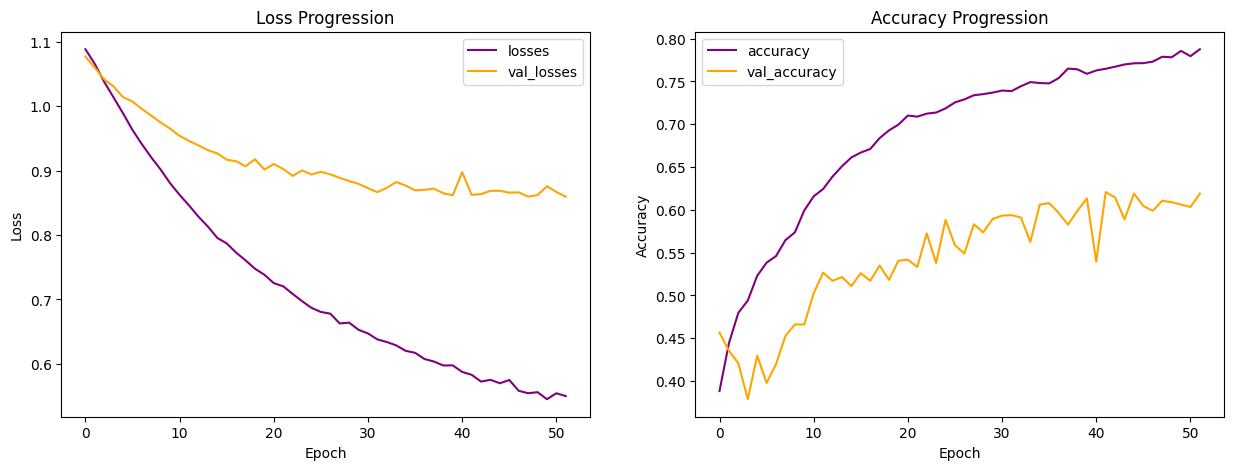

In [31]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [32]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [33]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.3828 - accuracy: 0.8569


In [34]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.86      0.86      0.86      1561
      comsan       0.89      0.87      0.88      1513
     eaywag1       0.81      0.84      0.83      1481

    accuracy                           0.86      4555
   macro avg       0.86      0.86      0.86      4555
weighted avg       0.86      0.86      0.86      4555



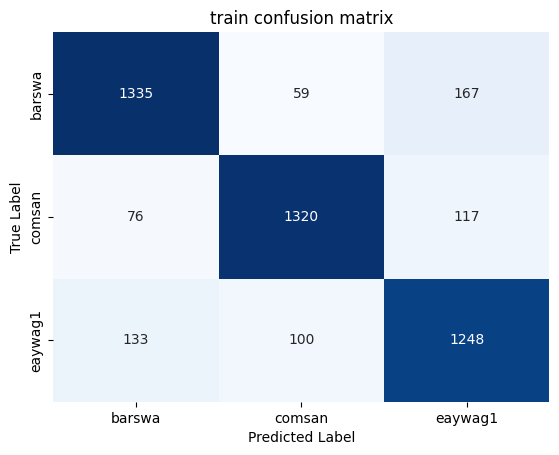

In [35]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [36]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [37]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.8869 - accuracy: 0.6258


In [38]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.63      0.61      0.62       612
      comsan       0.69      0.64      0.66       544
     eaywag1       0.57      0.63      0.60       629

    accuracy                           0.63      1785
   macro avg       0.63      0.63      0.63      1785
weighted avg       0.63      0.63      0.63      1785



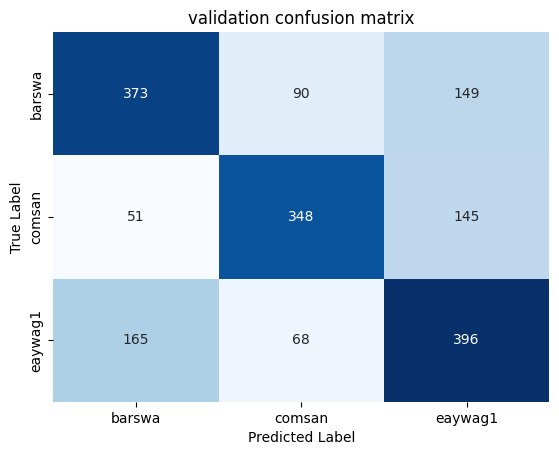

In [39]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2: build a FFNN model using only mfcc

In [40]:
training_features = train_features['mfcc']
training_features

array([[0.5833783 , 0.22506502, 0.25869003, ..., 0.528492  , 0.5501944 ,
        0.48965213],
       [0.4864634 , 0.35865286, 0.4910516 , ..., 0.5454146 , 0.50195307,
        0.45545572],
       [0.64716303, 0.7078631 , 0.48685718, ..., 0.549427  , 0.52860636,
        0.50806916],
       ...,
       [0.6376454 , 0.45960918, 0.49562243, ..., 0.5027022 , 0.5048822 ,
        0.45358405],
       [0.58959544, 0.6458805 , 0.43479753, ..., 0.438079  , 0.4383929 ,
        0.4968035 ],
       [0.68126357, 0.56677604, 0.3727692 , ..., 0.57731795, 0.45324504,
        0.53578997]], dtype=float32)

In [41]:
training_features.shape

(4555, 20)

In [42]:
validation_features = val_features['mfcc']
validation_features

array([[0.80559886, 0.5076871 , 0.4036126 , ..., 0.4283236 , 0.44799295,
        0.4120284 ],
       [0.8466713 , 0.65463865, 0.475306  , ..., 0.34799436, 0.3607207 ,
        0.34246522],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.5218609 , 0.5173474 ,
        0.51753634],
       ...,
       [0.51478726, 0.55654746, 0.3369657 , ..., 0.52973926, 0.5469891 ,
        0.44144177],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.40733263, 0.44733283,
        0.43509516],
       [0.76998335, 0.7078779 , 0.552503  , ..., 0.36064342, 0.40653053,
        0.40061882]], dtype=float32)

In [43]:
validation_features.shape

(1785, 20)

'best_epoch:'

78

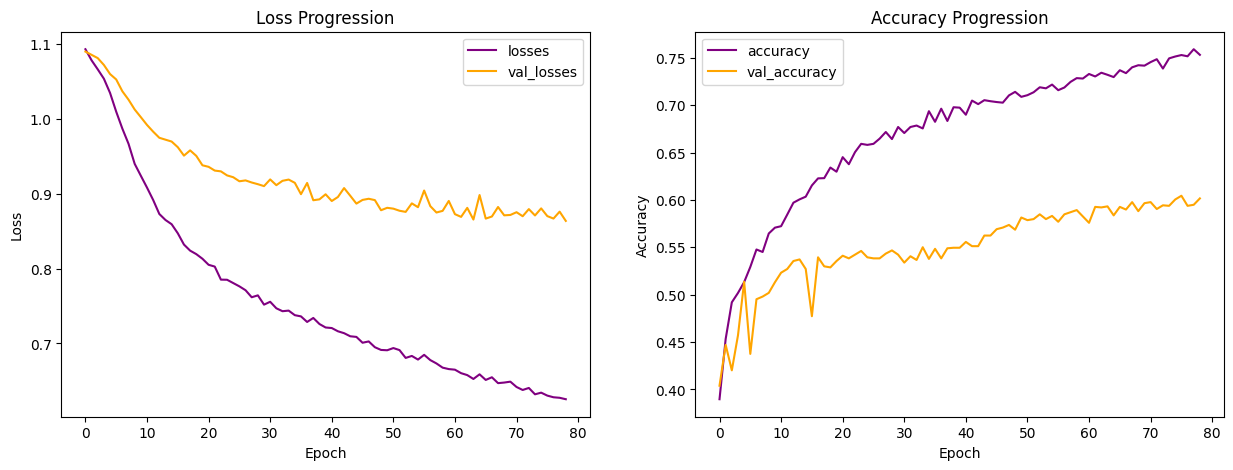

In [44]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [45]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [46]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.5502 - accuracy: 0.7914


In [47]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.77      0.85      0.81      1561
      comsan       0.82      0.83      0.82      1513
     eaywag1       0.78      0.70      0.74      1481

    accuracy                           0.79      4555
   macro avg       0.79      0.79      0.79      4555
weighted avg       0.79      0.79      0.79      4555



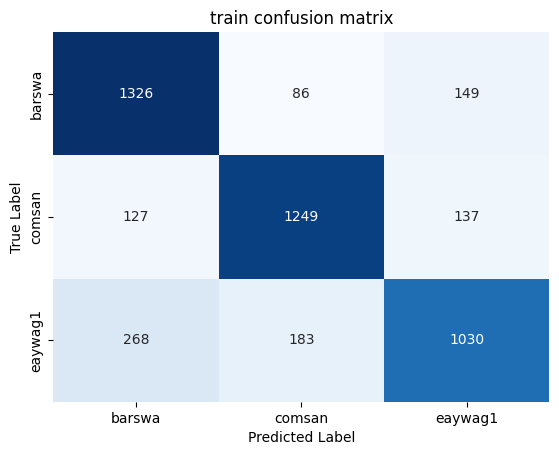

In [48]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [49]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [50]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.8797 - accuracy: 0.5882


In [51]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.54      0.58      0.56       612
      comsan       0.66      0.60      0.63       544
     eaywag1       0.58      0.59      0.59       629

    accuracy                           0.59      1785
   macro avg       0.59      0.59      0.59      1785
weighted avg       0.59      0.59      0.59      1785



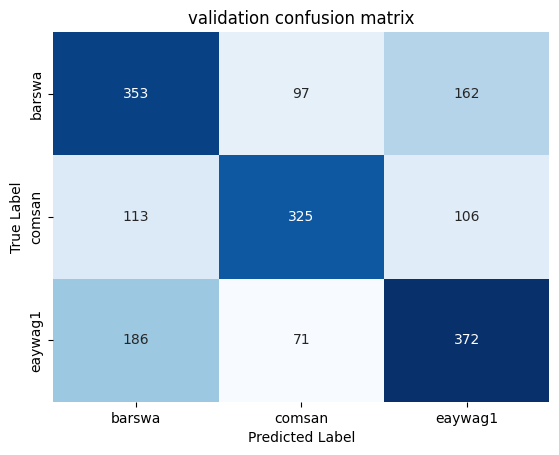

In [52]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2a: build a FFNN model using mfcc & chroma

In [53]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma']), axis=1)
training_features

array([[0.5833783 , 0.22506502, 0.25869003, ..., 0.49454433, 0.56662744,
        0.52319276],
       [0.4864634 , 0.35865286, 0.4910516 , ..., 0.5507785 , 0.55441934,
        0.6685136 ],
       [0.64716303, 0.7078631 , 0.48685718, ..., 0.42460808, 0.42850575,
        0.39794114],
       ...,
       [0.6376454 , 0.45960918, 0.49562243, ..., 0.463085  , 0.48006254,
        0.44473255],
       [0.58959544, 0.6458805 , 0.43479753, ..., 0.4433777 , 0.47002983,
        0.4843438 ],
       [0.68126357, 0.56677604, 0.3727692 , ..., 0.553634  , 0.622626  ,
        0.54062194]], dtype=float32)

In [54]:
training_features.shape

(4555, 32)

In [55]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma']), axis=1)
validation_features

array([[0.80559886, 0.5076871 , 0.4036126 , ..., 0.4899757 , 0.4823381 ,
        0.45750022],
       [0.8466713 , 0.65463865, 0.475306  , ..., 0.4864146 , 0.42718074,
        0.4011602 ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.44105184, 0.5135748 ,
        0.42291683],
       ...,
       [0.51478726, 0.55654746, 0.3369657 , ..., 0.47660184, 0.32628843,
        0.4000715 ],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.4747986 , 0.50603   ,
        0.5932159 ],
       [0.76998335, 0.7078779 , 0.552503  , ..., 0.4166199 , 0.35024667,
        0.36430353]], dtype=float32)

In [56]:
validation_features.shape

(1785, 32)

'best_epoch:'

52

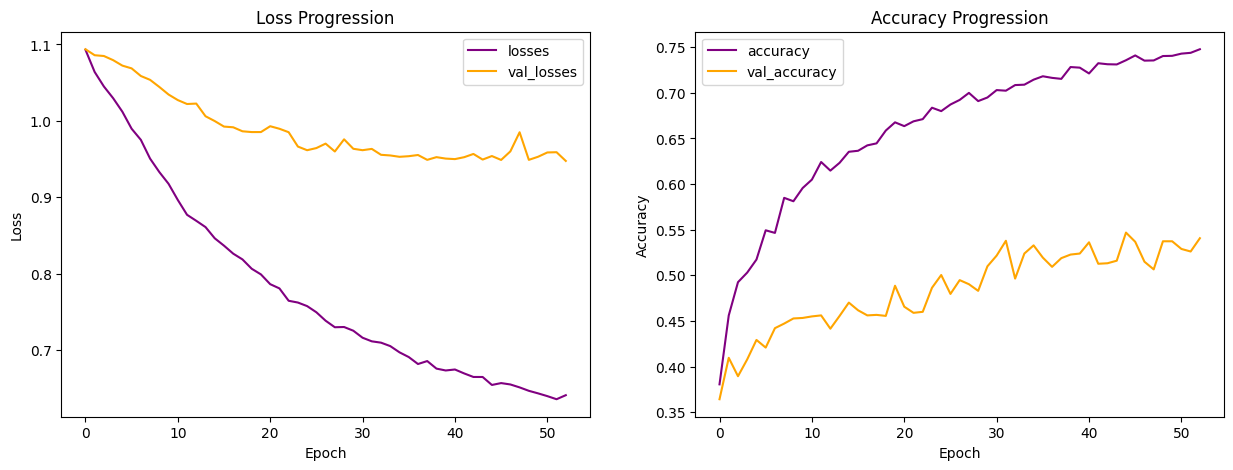

In [57]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [58]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [59]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.4877 - accuracy: 0.8121


In [60]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.81      0.84      0.82      1561
      comsan       0.88      0.81      0.84      1513
     eaywag1       0.76      0.78      0.77      1481

    accuracy                           0.81      4555
   macro avg       0.81      0.81      0.81      4555
weighted avg       0.81      0.81      0.81      4555



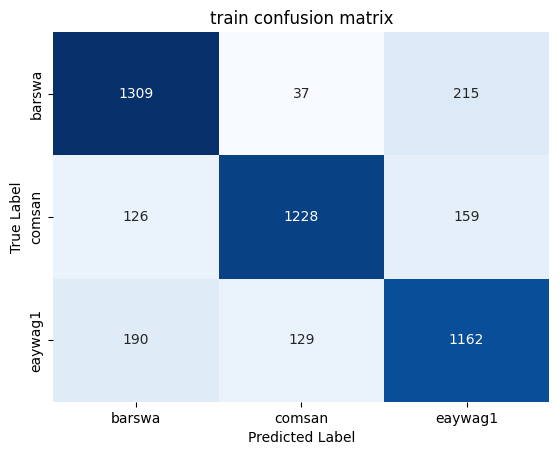

In [61]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [62]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [63]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.9780 - accuracy: 0.5585


In [64]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.55      0.57      0.56       612
      comsan       0.71      0.58      0.64       544
     eaywag1       0.47      0.53      0.50       629

    accuracy                           0.56      1785
   macro avg       0.58      0.56      0.57      1785
weighted avg       0.57      0.56      0.56      1785



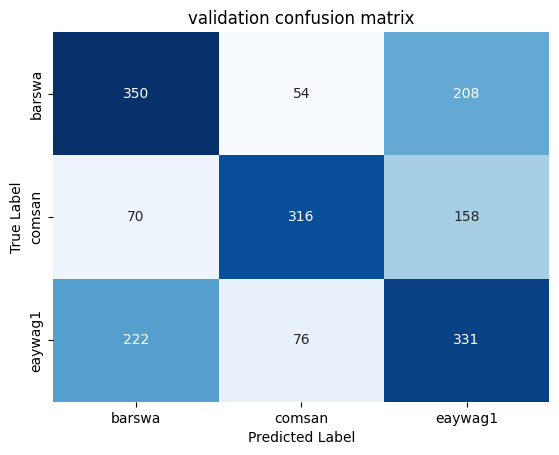

In [65]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2b: build a FFNN model using mfcc & rms

In [66]:
training_features = np.concatenate((train_features['mfcc'], train_features['rms']), axis=1)
training_features

array([[0.5833783 , 0.22506502, 0.25869003, ..., 0.5501944 , 0.48965213,
        0.05819931],
       [0.4864634 , 0.35865286, 0.4910516 , ..., 0.50195307, 0.45545572,
        0.0413979 ],
       [0.64716303, 0.7078631 , 0.48685718, ..., 0.52860636, 0.50806916,
        0.01589111],
       ...,
       [0.6376454 , 0.45960918, 0.49562243, ..., 0.5048822 , 0.45358405,
        0.08726039],
       [0.58959544, 0.6458805 , 0.43479753, ..., 0.4383929 , 0.4968035 ,
        0.01988466],
       [0.68126357, 0.56677604, 0.3727692 , ..., 0.45324504, 0.53578997,
        0.04376264]], dtype=float32)

In [67]:
training_features.shape

(4555, 21)

In [68]:
validation_features = np.concatenate((val_features['mfcc'], val_features['rms']), axis=1)
validation_features

array([[0.80559886, 0.5076871 , 0.4036126 , ..., 0.44799295, 0.4120284 ,
        0.08209055],
       [0.8466713 , 0.65463865, 0.475306  , ..., 0.3607207 , 0.34246522,
        0.13084483],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.5173474 , 0.51753634,
        0.012478  ],
       ...,
       [0.51478726, 0.55654746, 0.3369657 , ..., 0.5469891 , 0.44144177,
        0.00578654],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.44733283, 0.43509516,
        0.00905502],
       [0.76998335, 0.7078779 , 0.552503  , ..., 0.40653053, 0.40061882,
        0.08512645]], dtype=float32)

In [69]:
validation_features.shape

(1785, 21)

'best_epoch:'

38

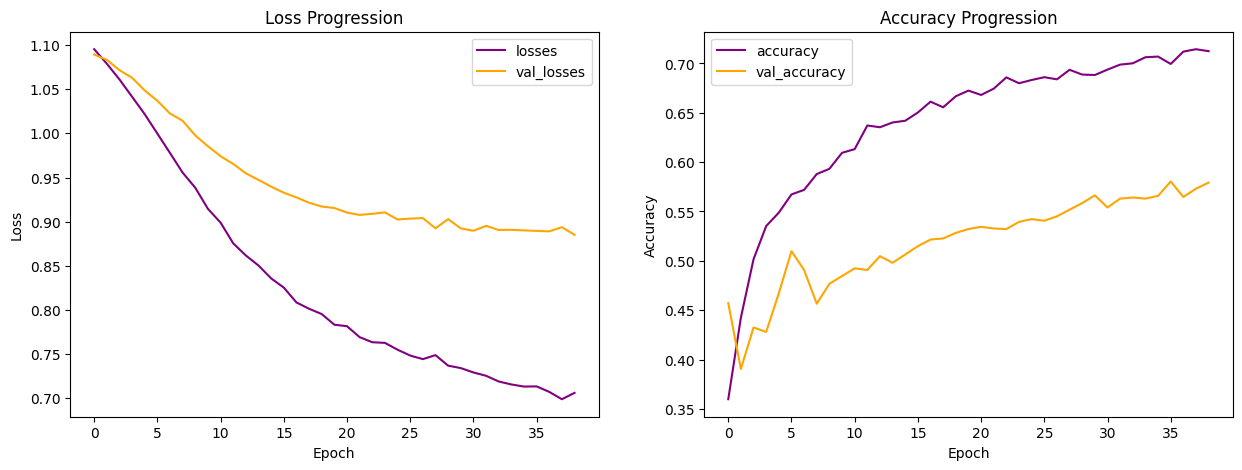

In [70]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [71]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [72]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_rms'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.5463 - accuracy: 0.7952


In [73]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.74      0.88      0.81      1561
      comsan       0.86      0.82      0.84      1513
     eaywag1       0.80      0.68      0.73      1481

    accuracy                           0.80      4555
   macro avg       0.80      0.79      0.79      4555
weighted avg       0.80      0.80      0.79      4555



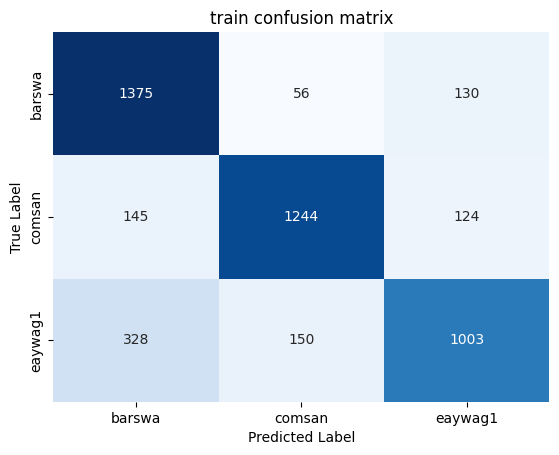

In [74]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [75]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [76]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_rms'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.9106 - accuracy: 0.5922


In [77]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.54      0.62      0.58       612
      comsan       0.71      0.58      0.64       544
     eaywag1       0.56      0.58      0.57       629

    accuracy                           0.59      1785
   macro avg       0.61      0.59      0.60      1785
weighted avg       0.60      0.59      0.59      1785



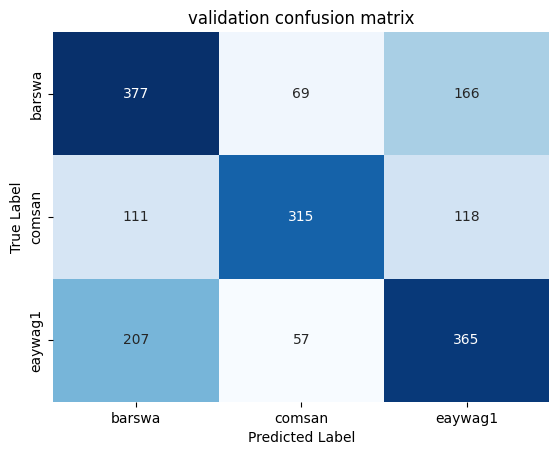

In [78]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2c: build a FFNN model using mfcc & spectral_centroid

In [79]:
training_features = np.concatenate((train_features['mfcc'], train_features['spectral_centroid']), axis=1)
training_features

array([[0.5833783 , 0.22506502, 0.25869003, ..., 0.5501944 , 0.48965213,
        0.56710416],
       [0.4864634 , 0.35865286, 0.4910516 , ..., 0.50195307, 0.45545572,
        0.5795631 ],
       [0.64716303, 0.7078631 , 0.48685718, ..., 0.52860636, 0.50806916,
        0.25585994],
       ...,
       [0.6376454 , 0.45960918, 0.49562243, ..., 0.5048822 , 0.45358405,
        0.6099158 ],
       [0.58959544, 0.6458805 , 0.43479753, ..., 0.4383929 , 0.4968035 ,
        0.33660418],
       [0.68126357, 0.56677604, 0.3727692 , ..., 0.45324504, 0.53578997,
        0.41118023]], dtype=float32)

In [80]:
training_features.shape

(4555, 21)

In [81]:
validation_features = np.concatenate((val_features['mfcc'], val_features['spectral_centroid']), axis=1)
validation_features

array([[0.80559886, 0.5076871 , 0.4036126 , ..., 0.44799295, 0.4120284 ,
        0.48029712],
       [0.8466713 , 0.65463865, 0.475306  , ..., 0.3607207 , 0.34246522,
        0.3105183 ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.5173474 , 0.51753634,
        0.45049974],
       ...,
       [0.51478726, 0.55654746, 0.3369657 , ..., 0.5469891 , 0.44144177,
        0.38147807],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.44733283, 0.43509516,
        0.4029764 ],
       [0.76998335, 0.7078779 , 0.552503  , ..., 0.40653053, 0.40061882,
        0.23552114]], dtype=float32)

In [82]:
validation_features.shape

(1785, 21)

'best_epoch:'

92

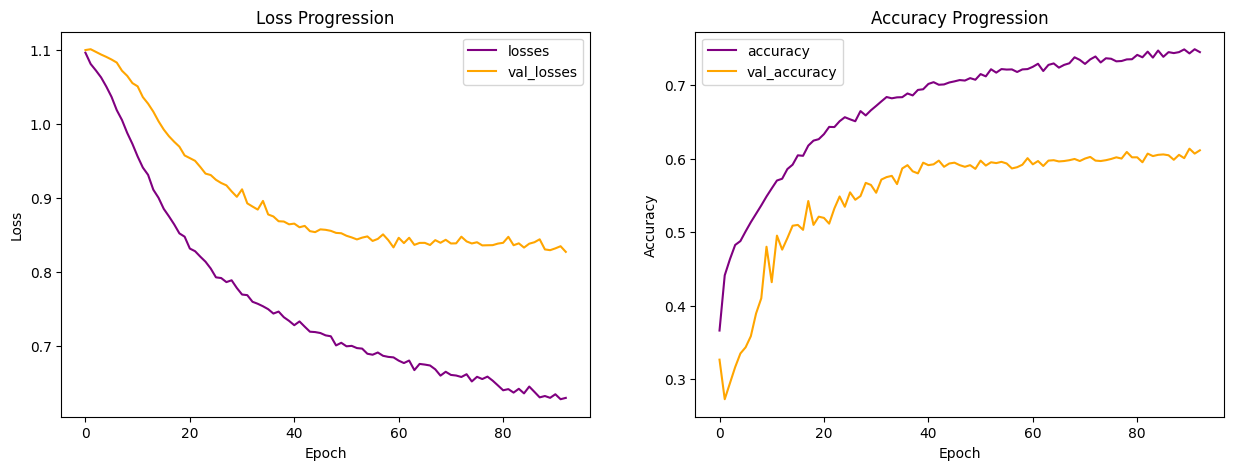

In [83]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [84]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [85]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_spectral_centroid'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.5776 - accuracy: 0.7708


In [86]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.78      0.81      0.79      1561
      comsan       0.82      0.77      0.79      1513
     eaywag1       0.72      0.73      0.72      1481

    accuracy                           0.77      4555
   macro avg       0.77      0.77      0.77      4555
weighted avg       0.77      0.77      0.77      4555



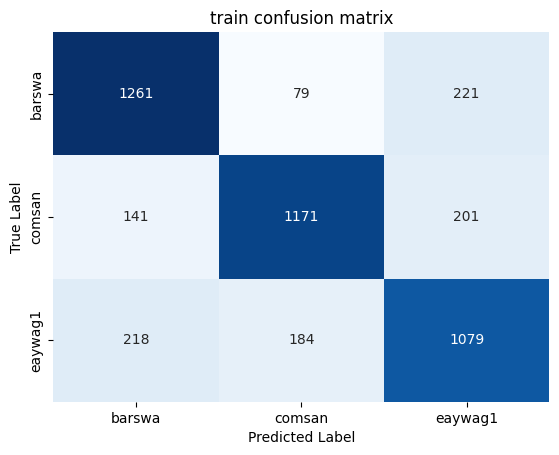

In [87]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [88]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [89]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_spectral_centroid'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.8285 - accuracy: 0.6129


In [90]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.58      0.57      0.57       612
      comsan       0.74      0.62      0.68       544
     eaywag1       0.56      0.64      0.60       629

    accuracy                           0.61      1785
   macro avg       0.63      0.61      0.62      1785
weighted avg       0.62      0.61      0.61      1785



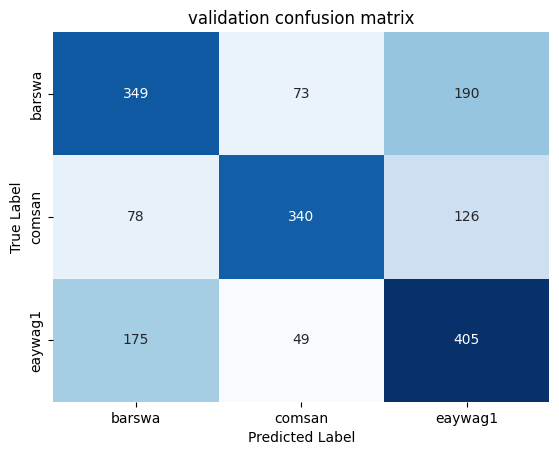

In [91]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2d: build a FFNN model using mfcc & continent

In [92]:
training_features = np.concatenate((train_features['mfcc'], train_continents), axis=1)
training_features

array([[0.58337831, 0.22506502, 0.25869003, ..., 0.        , 1.        ,
        0.        ],
       [0.4864634 , 0.35865286, 0.49105161, ..., 0.        , 1.        ,
        0.        ],
       [0.64716303, 0.70786309, 0.48685718, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.63764542, 0.45960918, 0.49562243, ..., 0.        , 1.        ,
        0.        ],
       [0.58959544, 0.64588052, 0.43479753, ..., 0.        , 1.        ,
        0.        ],
       [0.68126357, 0.56677604, 0.37276921, ..., 0.        , 1.        ,
        0.        ]])

In [93]:
training_features.shape

(4555, 25)

In [94]:
validation_features = np.concatenate((val_features['mfcc'], val_continents), axis=1)
validation_features

array([[0.80559886, 0.50768709, 0.40361261, ..., 0.        , 1.        ,
        0.        ],
       [0.84667128, 0.65463865, 0.475306  , ..., 0.        , 0.        ,
        0.        ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.51478726, 0.55654746, 0.33696571, ..., 1.        , 0.        ,
        0.        ],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.        , 1.        ,
        0.        ],
       [0.76998335, 0.70787787, 0.55250299, ..., 0.        , 0.        ,
        0.        ]])

In [95]:
validation_features.shape

(1785, 25)

'best_epoch:'

144

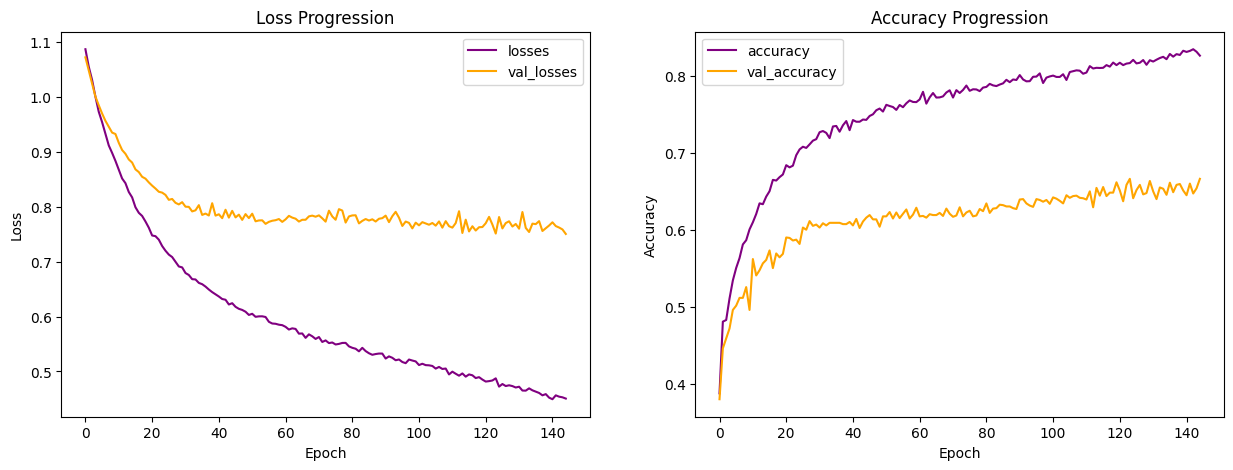

In [96]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [97]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [98]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_continent'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.4147 - accuracy: 0.8474


In [99]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.87      0.84      0.85      1561
      comsan       0.89      0.89      0.89      1513
     eaywag1       0.79      0.81      0.80      1481

    accuracy                           0.85      4555
   macro avg       0.85      0.85      0.85      4555
weighted avg       0.85      0.85      0.85      4555



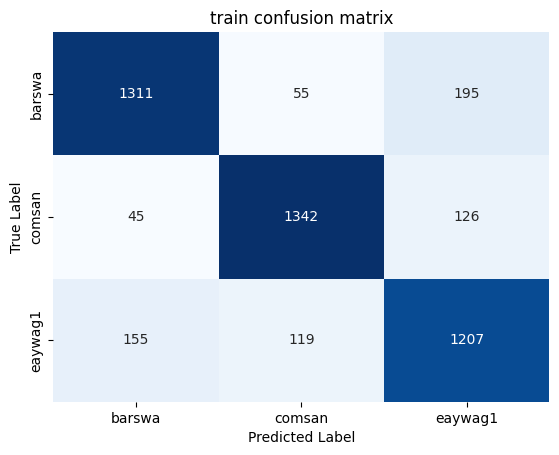

In [100]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [101]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [102]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_continent'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.7504 - accuracy: 0.6661


In [103]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.71      0.64      0.67       612
      comsan       0.74      0.70      0.72       544
     eaywag1       0.58      0.67      0.62       629

    accuracy                           0.67      1785
   macro avg       0.68      0.67      0.67      1785
weighted avg       0.67      0.67      0.67      1785



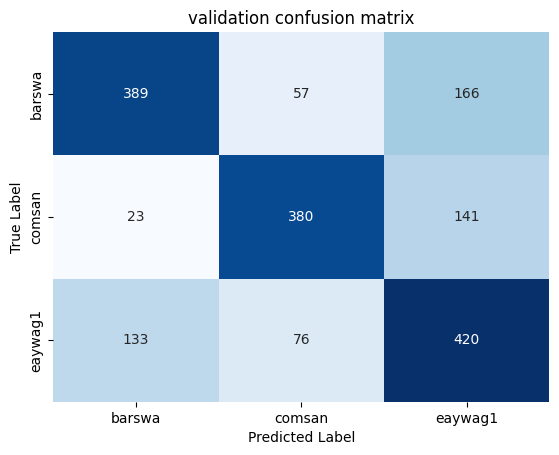

In [104]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2e: build a FFNN model using mfcc, chroma & rms

In [105]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms']), axis=1)
training_features

array([[0.5833783 , 0.22506502, 0.25869003, ..., 0.56662744, 0.52319276,
        0.05819931],
       [0.4864634 , 0.35865286, 0.4910516 , ..., 0.55441934, 0.6685136 ,
        0.0413979 ],
       [0.64716303, 0.7078631 , 0.48685718, ..., 0.42850575, 0.39794114,
        0.01589111],
       ...,
       [0.6376454 , 0.45960918, 0.49562243, ..., 0.48006254, 0.44473255,
        0.08726039],
       [0.58959544, 0.6458805 , 0.43479753, ..., 0.47002983, 0.4843438 ,
        0.01988466],
       [0.68126357, 0.56677604, 0.3727692 , ..., 0.622626  , 0.54062194,
        0.04376264]], dtype=float32)

In [106]:
training_features.shape

(4555, 33)

In [107]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms']), axis=1)
validation_features

array([[0.80559886, 0.5076871 , 0.4036126 , ..., 0.4823381 , 0.45750022,
        0.08209055],
       [0.8466713 , 0.65463865, 0.475306  , ..., 0.42718074, 0.4011602 ,
        0.13084483],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.5135748 , 0.42291683,
        0.012478  ],
       ...,
       [0.51478726, 0.55654746, 0.3369657 , ..., 0.32628843, 0.4000715 ,
        0.00578654],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.50603   , 0.5932159 ,
        0.00905502],
       [0.76998335, 0.7078779 , 0.552503  , ..., 0.35024667, 0.36430353,
        0.08512645]], dtype=float32)

In [108]:
validation_features.shape

(1785, 33)

'best_epoch:'

39

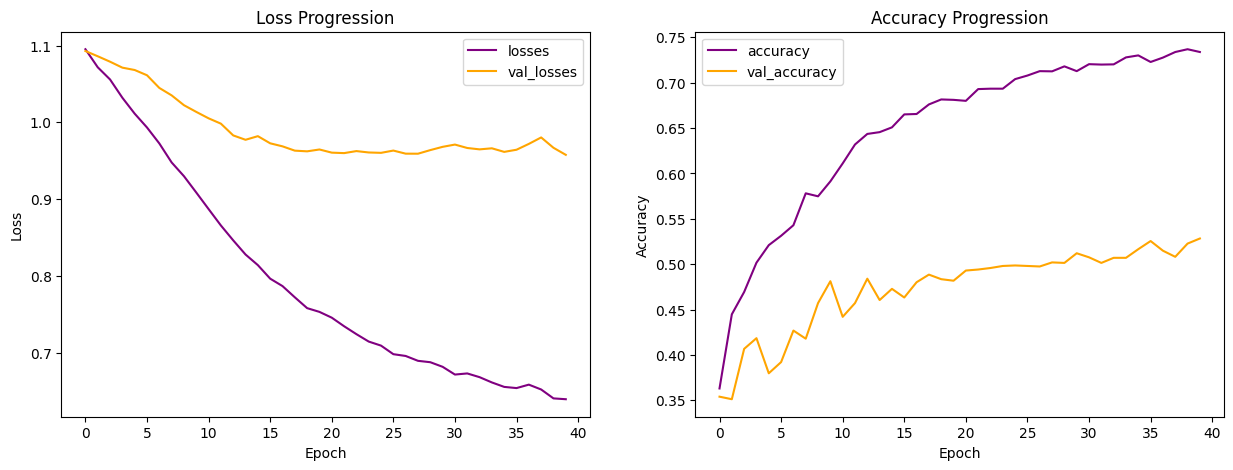

In [109]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [110]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [111]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma_rms'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.4661 - accuracy: 0.8178


In [112]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.81      0.83      0.82      1561
      comsan       0.86      0.86      0.86      1513
     eaywag1       0.79      0.76      0.77      1481

    accuracy                           0.82      4555
   macro avg       0.82      0.82      0.82      4555
weighted avg       0.82      0.82      0.82      4555



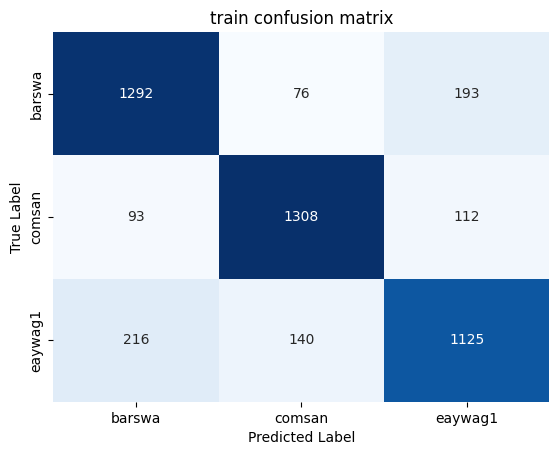

In [113]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [114]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [115]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma_rms'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 1.0202 - accuracy: 0.5658


In [116]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.54      0.62      0.58       612
      comsan       0.67      0.62      0.64       544
     eaywag1       0.51      0.47      0.49       629

    accuracy                           0.57      1785
   macro avg       0.57      0.57      0.57      1785
weighted avg       0.57      0.57      0.57      1785



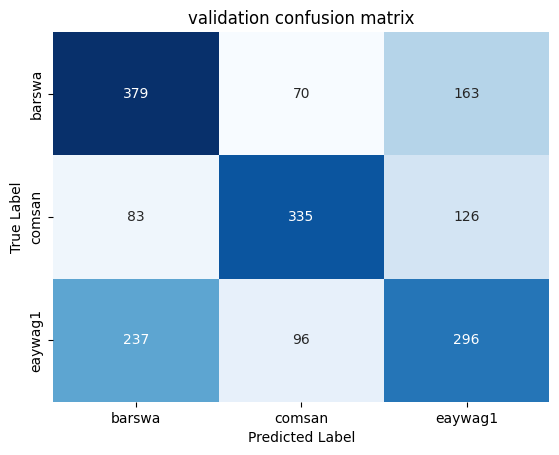

In [117]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2f: build a FFNN model using mfcc, chroma & spectral_centroid

In [118]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['spectral_centroid']), axis=1)
training_features

array([[0.5833783 , 0.22506502, 0.25869003, ..., 0.56662744, 0.52319276,
        0.56710416],
       [0.4864634 , 0.35865286, 0.4910516 , ..., 0.55441934, 0.6685136 ,
        0.5795631 ],
       [0.64716303, 0.7078631 , 0.48685718, ..., 0.42850575, 0.39794114,
        0.25585994],
       ...,
       [0.6376454 , 0.45960918, 0.49562243, ..., 0.48006254, 0.44473255,
        0.6099158 ],
       [0.58959544, 0.6458805 , 0.43479753, ..., 0.47002983, 0.4843438 ,
        0.33660418],
       [0.68126357, 0.56677604, 0.3727692 , ..., 0.622626  , 0.54062194,
        0.41118023]], dtype=float32)

In [119]:
training_features.shape

(4555, 33)

In [120]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['spectral_centroid']), axis=1)
validation_features

array([[0.80559886, 0.5076871 , 0.4036126 , ..., 0.4823381 , 0.45750022,
        0.48029712],
       [0.8466713 , 0.65463865, 0.475306  , ..., 0.42718074, 0.4011602 ,
        0.3105183 ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.5135748 , 0.42291683,
        0.45049974],
       ...,
       [0.51478726, 0.55654746, 0.3369657 , ..., 0.32628843, 0.4000715 ,
        0.38147807],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.50603   , 0.5932159 ,
        0.4029764 ],
       [0.76998335, 0.7078779 , 0.552503  , ..., 0.35024667, 0.36430353,
        0.23552114]], dtype=float32)

In [121]:
validation_features.shape

(1785, 33)

'best_epoch:'

53

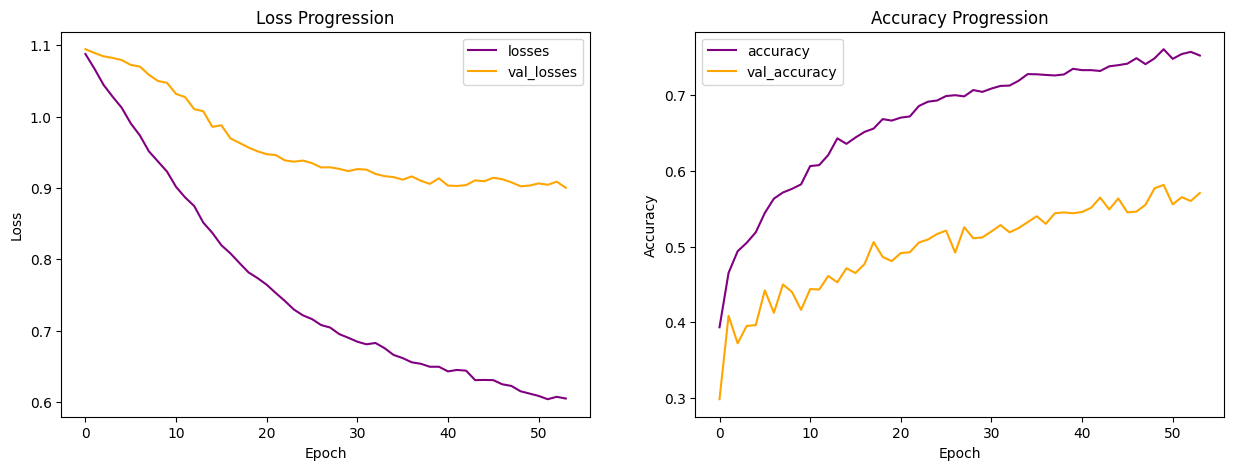

In [122]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [123]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [124]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma_spectral_centroid'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.4530 - accuracy: 0.8283


In [125]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.82      0.83      0.83      1561
      comsan       0.91      0.85      0.88      1513
     eaywag1       0.76      0.81      0.78      1481

    accuracy                           0.83      4555
   macro avg       0.83      0.83      0.83      4555
weighted avg       0.83      0.83      0.83      4555



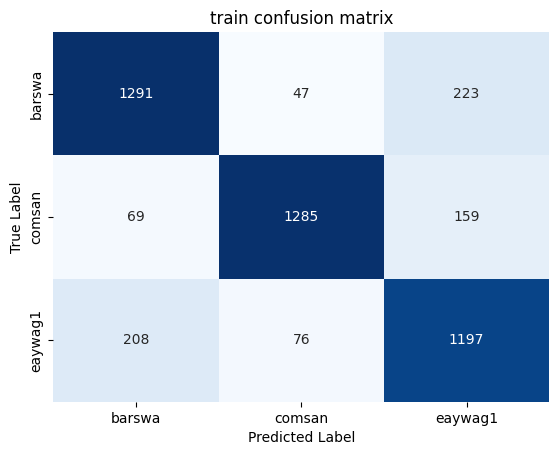

In [126]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [127]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [128]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma_spectral_centroid'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 2ms/step - loss: 0.9372 - accuracy: 0.5888


In [129]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.58      0.57      0.57       612
      comsan       0.71      0.67      0.69       544
     eaywag1       0.51      0.54      0.52       629

    accuracy                           0.59      1785
   macro avg       0.60      0.59      0.59      1785
weighted avg       0.59      0.59      0.59      1785



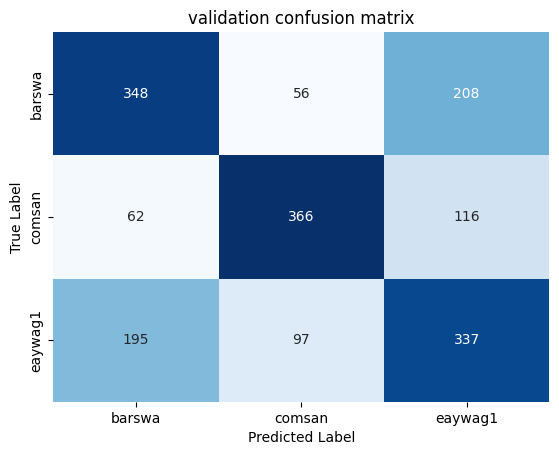

In [130]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2g: build a FFNN model using mfcc, chroma & continent

In [131]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_continents), axis=1)
training_features

array([[0.58337831, 0.22506502, 0.25869003, ..., 0.        , 1.        ,
        0.        ],
       [0.4864634 , 0.35865286, 0.49105161, ..., 0.        , 1.        ,
        0.        ],
       [0.64716303, 0.70786309, 0.48685718, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.63764542, 0.45960918, 0.49562243, ..., 0.        , 1.        ,
        0.        ],
       [0.58959544, 0.64588052, 0.43479753, ..., 0.        , 1.        ,
        0.        ],
       [0.68126357, 0.56677604, 0.37276921, ..., 0.        , 1.        ,
        0.        ]])

In [132]:
training_features.shape

(4555, 37)

In [133]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_continents), axis=1)
validation_features

array([[0.80559886, 0.50768709, 0.40361261, ..., 0.        , 1.        ,
        0.        ],
       [0.84667128, 0.65463865, 0.475306  , ..., 0.        , 0.        ,
        0.        ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.51478726, 0.55654746, 0.33696571, ..., 1.        , 0.        ,
        0.        ],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.        , 1.        ,
        0.        ],
       [0.76998335, 0.70787787, 0.55250299, ..., 0.        , 0.        ,
        0.        ]])

In [134]:
validation_features.shape

(1785, 37)

'best_epoch:'

57

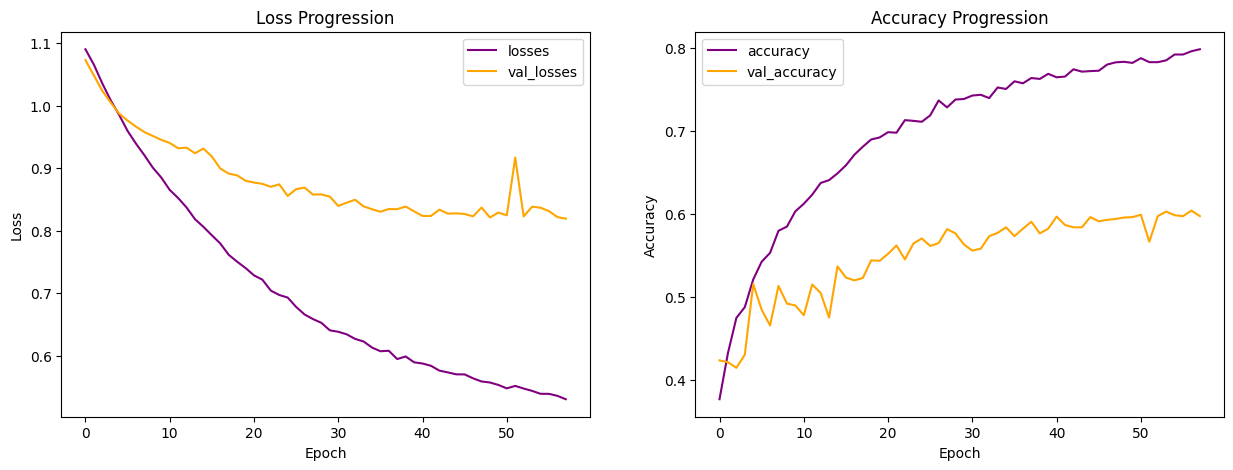

In [135]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [136]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [137]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma_continent'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.4041 - accuracy: 0.8514


In [138]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.92      0.82      0.87      1561
      comsan       0.88      0.89      0.88      1513
     eaywag1       0.77      0.85      0.80      1481

    accuracy                           0.85      4555
   macro avg       0.86      0.85      0.85      4555
weighted avg       0.86      0.85      0.85      4555



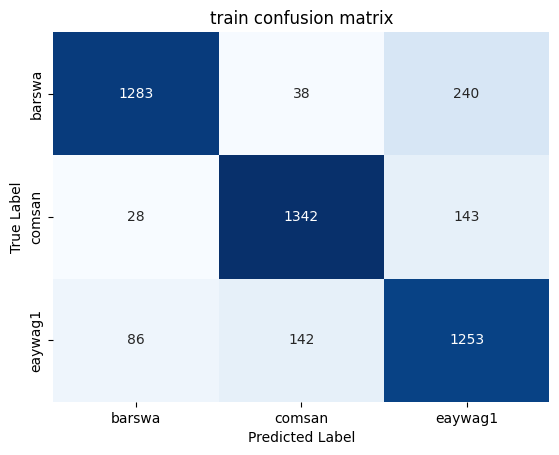

In [139]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [140]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [141]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma_continent'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.8338 - accuracy: 0.6291


In [142]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.65      0.56      0.60       612
      comsan       0.72      0.65      0.68       544
     eaywag1       0.56      0.68      0.61       629

    accuracy                           0.63      1785
   macro avg       0.64      0.63      0.63      1785
weighted avg       0.64      0.63      0.63      1785



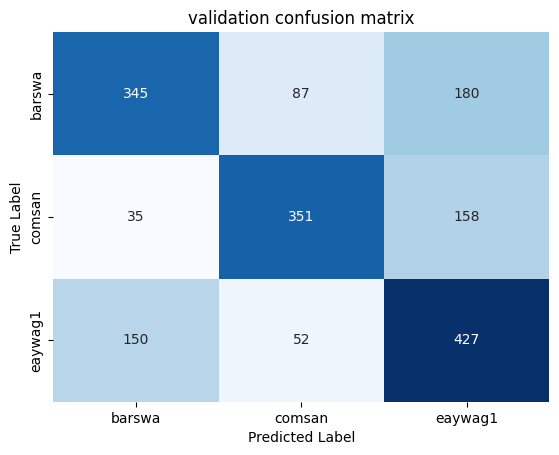

In [143]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2h: build a FFNN model using mfcc, rms & spectral_centroid

In [144]:
training_features = np.concatenate((train_features['mfcc'], train_features['rms'], train_features['spectral_centroid']), axis=1)
training_features

array([[0.5833783 , 0.22506502, 0.25869003, ..., 0.48965213, 0.05819931,
        0.56710416],
       [0.4864634 , 0.35865286, 0.4910516 , ..., 0.45545572, 0.0413979 ,
        0.5795631 ],
       [0.64716303, 0.7078631 , 0.48685718, ..., 0.50806916, 0.01589111,
        0.25585994],
       ...,
       [0.6376454 , 0.45960918, 0.49562243, ..., 0.45358405, 0.08726039,
        0.6099158 ],
       [0.58959544, 0.6458805 , 0.43479753, ..., 0.4968035 , 0.01988466,
        0.33660418],
       [0.68126357, 0.56677604, 0.3727692 , ..., 0.53578997, 0.04376264,
        0.41118023]], dtype=float32)

In [145]:
training_features.shape

(4555, 22)

In [146]:
validation_features = np.concatenate((val_features['mfcc'], val_features['rms'], val_features['spectral_centroid']), axis=1)
validation_features

array([[0.80559886, 0.5076871 , 0.4036126 , ..., 0.4120284 , 0.08209055,
        0.48029712],
       [0.8466713 , 0.65463865, 0.475306  , ..., 0.34246522, 0.13084483,
        0.3105183 ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.51753634, 0.012478  ,
        0.45049974],
       ...,
       [0.51478726, 0.55654746, 0.3369657 , ..., 0.44144177, 0.00578654,
        0.38147807],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.43509516, 0.00905502,
        0.4029764 ],
       [0.76998335, 0.7078779 , 0.552503  , ..., 0.40061882, 0.08512645,
        0.23552114]], dtype=float32)

In [147]:
validation_features.shape

(1785, 22)

'best_epoch:'

108

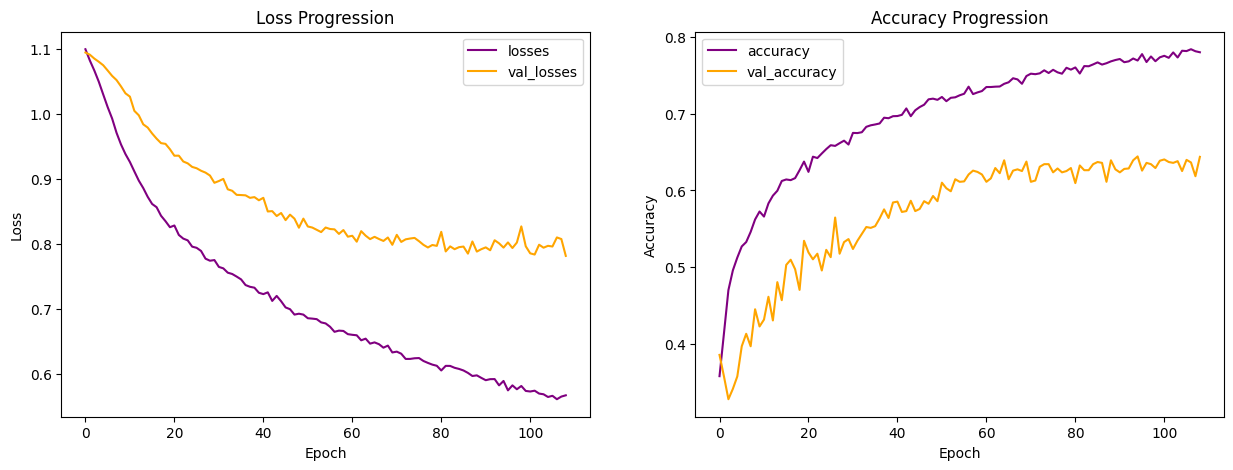

In [148]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [149]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [150]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_rms_spectral_centroid'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.5307 - accuracy: 0.7936


In [151]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.78      0.83      0.80      1561
      comsan       0.83      0.84      0.84      1513
     eaywag1       0.77      0.71      0.74      1481

    accuracy                           0.79      4555
   macro avg       0.79      0.79      0.79      4555
weighted avg       0.79      0.79      0.79      4555



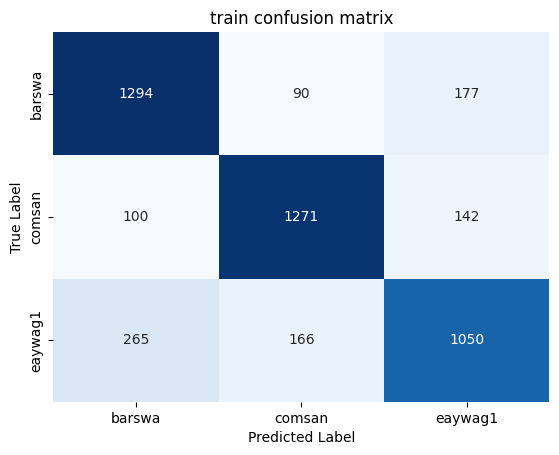

In [152]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [153]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [154]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_rms_spectral_centroid'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.7815 - accuracy: 0.6437


In [155]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.61      0.63      0.62       612
      comsan       0.73      0.70      0.72       544
     eaywag1       0.60      0.61      0.61       629

    accuracy                           0.64      1785
   macro avg       0.65      0.65      0.65      1785
weighted avg       0.65      0.64      0.64      1785



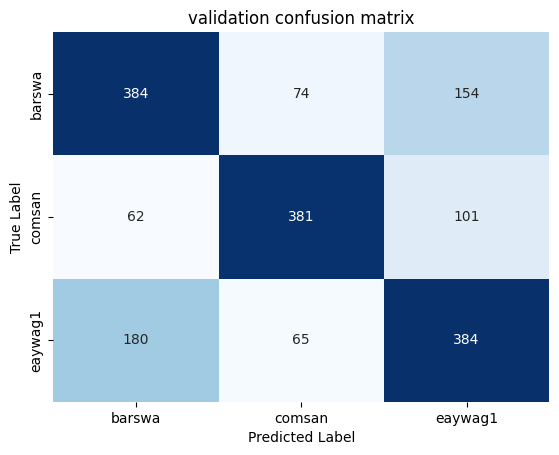

In [156]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2i: build a FFNN model using mfcc, rms & continent

In [157]:
training_features = np.concatenate((train_features['mfcc'], train_features['rms'], train_continents), axis=1)
training_features

array([[0.58337831, 0.22506502, 0.25869003, ..., 0.        , 1.        ,
        0.        ],
       [0.4864634 , 0.35865286, 0.49105161, ..., 0.        , 1.        ,
        0.        ],
       [0.64716303, 0.70786309, 0.48685718, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.63764542, 0.45960918, 0.49562243, ..., 0.        , 1.        ,
        0.        ],
       [0.58959544, 0.64588052, 0.43479753, ..., 0.        , 1.        ,
        0.        ],
       [0.68126357, 0.56677604, 0.37276921, ..., 0.        , 1.        ,
        0.        ]])

In [158]:
training_features.shape

(4555, 26)

In [159]:
validation_features = np.concatenate((val_features['mfcc'], val_features['rms'], val_continents), axis=1)
validation_features

array([[0.80559886, 0.50768709, 0.40361261, ..., 0.        , 1.        ,
        0.        ],
       [0.84667128, 0.65463865, 0.475306  , ..., 0.        , 0.        ,
        0.        ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.51478726, 0.55654746, 0.33696571, ..., 1.        , 0.        ,
        0.        ],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.        , 1.        ,
        0.        ],
       [0.76998335, 0.70787787, 0.55250299, ..., 0.        , 0.        ,
        0.        ]])

In [160]:
validation_features.shape

(1785, 26)

'best_epoch:'

113

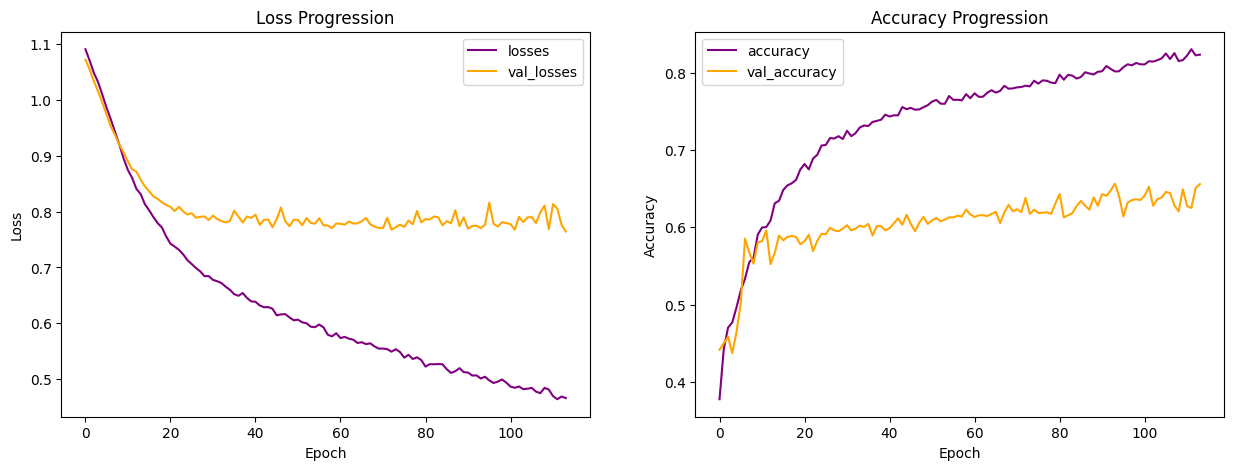

In [161]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [162]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [163]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_rms_continent'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.8393


In [164]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.86      0.85      0.85      1561
      comsan       0.89      0.85      0.87      1513
     eaywag1       0.77      0.82      0.79      1481

    accuracy                           0.84      4555
   macro avg       0.84      0.84      0.84      4555
weighted avg       0.84      0.84      0.84      4555



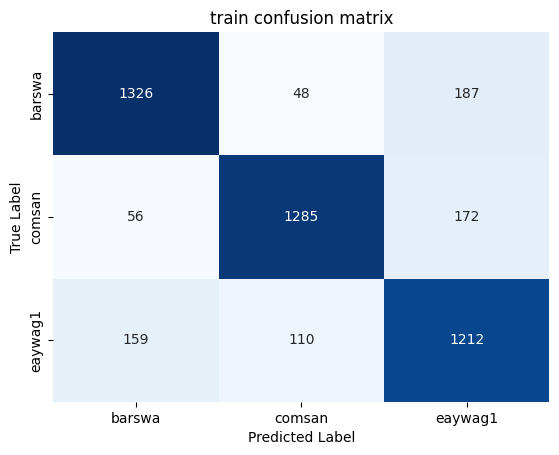

In [165]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [166]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [167]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_rms_continent'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 1ms/step - loss: 0.7644 - accuracy: 0.6560


In [168]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.67      0.61      0.64       612
      comsan       0.73      0.70      0.71       544
     eaywag1       0.59      0.67      0.62       629

    accuracy                           0.66      1785
   macro avg       0.66      0.66      0.66      1785
weighted avg       0.66      0.66      0.66      1785



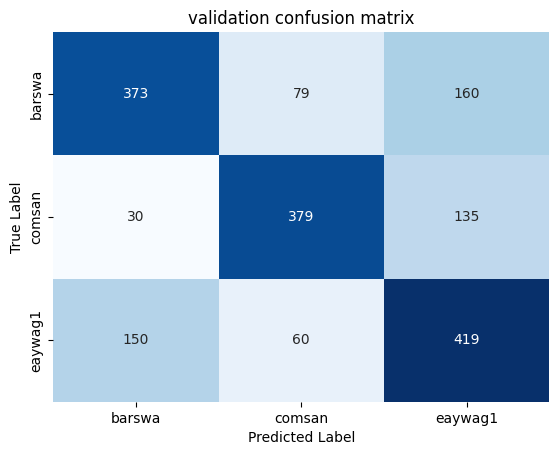

In [169]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# 4a-2j: build a FFNN model using mfcc, spectral_centroid & continent

In [170]:
training_features = np.concatenate((train_features['mfcc'], train_features['spectral_centroid'], train_continents), axis=1)
training_features

array([[0.58337831, 0.22506502, 0.25869003, ..., 0.        , 1.        ,
        0.        ],
       [0.4864634 , 0.35865286, 0.49105161, ..., 0.        , 1.        ,
        0.        ],
       [0.64716303, 0.70786309, 0.48685718, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.63764542, 0.45960918, 0.49562243, ..., 0.        , 1.        ,
        0.        ],
       [0.58959544, 0.64588052, 0.43479753, ..., 0.        , 1.        ,
        0.        ],
       [0.68126357, 0.56677604, 0.37276921, ..., 0.        , 1.        ,
        0.        ]])

In [171]:
training_features.shape

(4555, 26)

In [172]:
validation_features = np.concatenate((val_features['mfcc'], val_features['spectral_centroid'], val_continents), axis=1)
validation_features

array([[0.80559886, 0.50768709, 0.40361261, ..., 0.        , 1.        ,
        0.        ],
       [0.84667128, 0.65463865, 0.475306  , ..., 0.        , 0.        ,
        0.        ],
       [0.53523856, 0.60233414, 0.55321413, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.51478726, 0.55654746, 0.33696571, ..., 1.        , 0.        ,
        0.        ],
       [0.5877285 , 0.54515487, 0.35950956, ..., 0.        , 1.        ,
        0.        ],
       [0.76998335, 0.70787787, 0.55250299, ..., 0.        , 0.        ,
        0.        ]])

In [173]:
validation_features.shape

(1785, 26)

'best_epoch:'

60

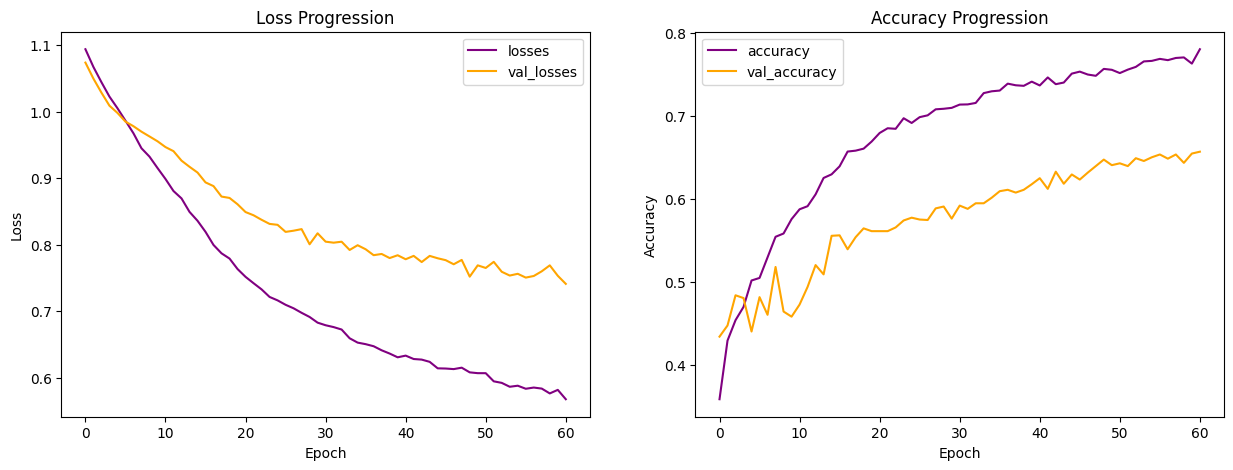

In [174]:
model = build_model(training_features, learning_rate=0.0001)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    start_from_epoch=100,
)

history = model.fit(
   x=training_features,
   y=train_y,
   epochs=300,
   validation_data=(validation_features, val_y),
   batch_size=32,
   callbacks=[callback],
   verbose=0)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

display('best_epoch:', best_epoch)

visualize(history, best_epoch)

## evaluate the results of the FFNN

`On training set`

In [175]:
# % of each class in training set
display((train_y == 0).sum()/len(train_y))
display((train_y == 1).sum()/len(train_y))
display((train_y == 2).sum()/len(train_y))

0.34270032930845223

0.33216245883644346

0.3251372118551043

In [176]:
# predict using the training set
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_spectral_centroid_continent'] = model.evaluate(training_features, train_y)[-1]

143/143 [==============================] - 0s 1ms/step - loss: 0.4583 - accuracy: 0.8263


In [177]:
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       0.85      0.86      0.85      1561
      comsan       0.85      0.84      0.85      1513
     eaywag1       0.78      0.77      0.78      1481

    accuracy                           0.83      4555
   macro avg       0.83      0.83      0.83      4555
weighted avg       0.83      0.83      0.83      4555



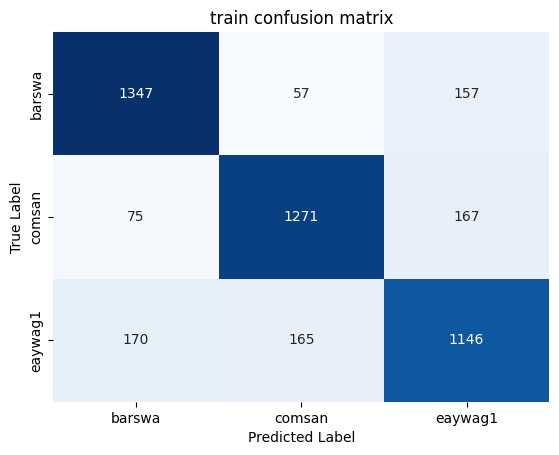

In [178]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

`On validation set`

In [179]:
# % of each class in validation set
display((val_y == 0).sum()/len(val_y))
display((val_y == 1).sum()/len(val_y))
display((val_y == 2).sum()/len(val_y))

0.34285714285714286

0.3047619047619048

0.3523809523809524

In [180]:
# predict using the validation set
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_spectral_centroid_continent'] = model.evaluate(validation_features, val_y)[-1]

56/56 [==============================] - 0s 2ms/step - loss: 0.7572 - accuracy: 0.6644


In [181]:
print('\nValidation Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))


Validation Classification Report

              precision    recall  f1-score   support

      barswa       0.68      0.66      0.67       612
      comsan       0.75      0.67      0.71       544
     eaywag1       0.59      0.66      0.63       629

    accuracy                           0.66      1785
   macro avg       0.67      0.66      0.67      1785
weighted avg       0.67      0.66      0.67      1785



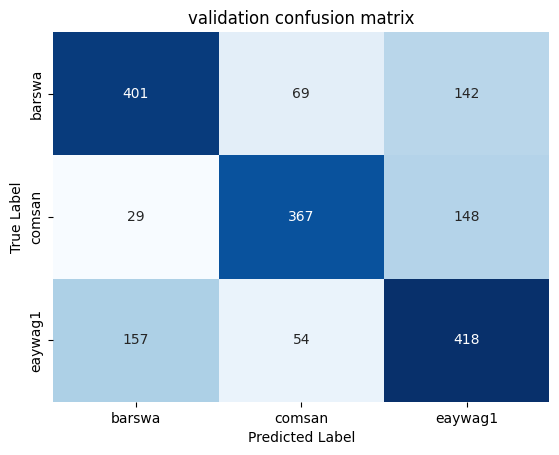

In [182]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('validation confusion matrix')
plt.show()

# Summary of all results

In [183]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Val_Accuracy')
result_df

,Features,Train_Accuracy,Val_Accuracy
2,mfcc_chroma,0.81,0.56
6,mfcc_chroma_rms,0.82,0.57
1,mfcc,0.79,0.59
3,mfcc_rms,0.80,0.59
7,mfcc_chroma_spectral_centroid,0.83,0.59
4,mfcc_spectral_centroid,0.77,0.61
0,all_features,0.86,0.63
8,mfcc_chroma_continent,0.85,0.63
9,mfcc_rms_spectral_centroid,0.79,0.64
10,mfcc_rms_continent,0.84,0.66
